# 1
Load the data and separate in X all the columns but the last one, in y the last column, then produce a pairplot of X and comment what you see.

In [262]:
import warnings

# Suppose you want to suppress the DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

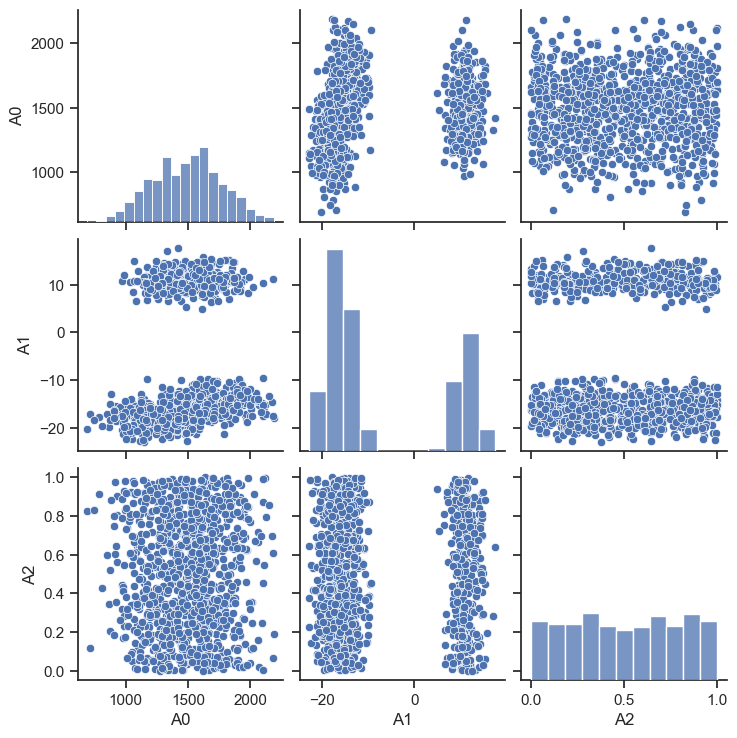

In [263]:
import pandas as pd
import seaborn as sns
df = pd.read_csv('./exam_2021_01_15.csv')

y = df['y']
X = df.drop(['y'], axis=1)

# display(X.head())
# display(y.head())

sns.pairplot(X)
# We can see that the distribution is not standardized because 
# they all have different measures

# 2
Find the best clustering scheme for X with a method of your choice, plot the silhouhette index for an appropriate range of parameters and show the chosen hyperparameter(s).

Consider carefully the number of clusters, simple optimisation of the silhouette will not be enough, decide visually the best number of clusters.

### Before we have to standardize the dataset

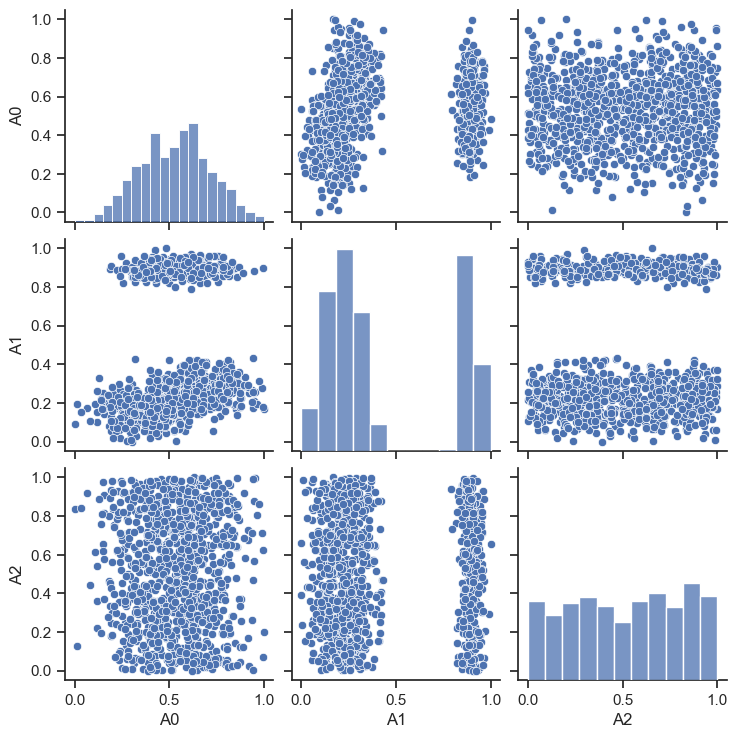

In [264]:
# 1) We normalize the dataset
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer() 
X_pt = pd.DataFrame(pt.fit_transform(X), columns=X.columns)

# 2) We rescale the dataset
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_st = pd.DataFrame(mms.fit_transform(X_pt), columns = X_pt.columns)

sns.pairplot(X_st)

# # Uncomment to see the result If we don't standardize the matrix
# X_st = X


### KMeans + Elbow Method

In [265]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

k_range = list(range(2,11)) # set the range of k values to test 
parameters_km = [{'n_clusters': k_range}]
pg = list(ParameterGrid(parameters_km))
random_state=23

inertias_km = []
silhouette_scores_km = []

for i in range(len(pg)):
    km = KMeans(**(pg[i]), random_state=random_state)
    y_km = km.fit_predict(X_st)
    inertias_km.append(km.inertia_) # Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.
    silhouette_scores_km.append(silhouette_score(X_st,y_km))

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [266]:
from matplotlib import pyplot as plt

def two_plots(x, y1, y2, xlabel, y1label, y2label):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

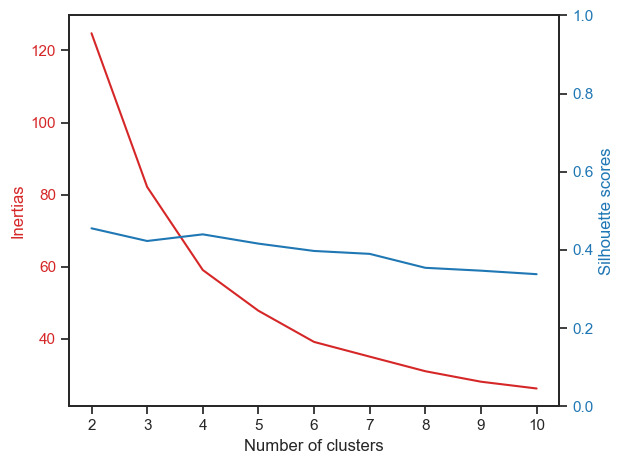

In [267]:
two_plots(x=k_range, y1=inertias_km, y2=silhouette_scores_km
          , xlabel='Number of clusters', y1label='Inertias', y2label='Silhouette scores'
         )

I visually notice that the elbow is present with respect to K=4 clusters but also K=3 isn't bad and by trying it, we can visually notice taht it provides a better clustering

# 3
fit the clustering scheme store the cluster labels in y_km and output the silhouette score

In [268]:
# Test the clustering model
k=3
km = KMeans(n_clusters=k, random_state=random_state)
y_km = km.fit_predict(X_st)
print(f"The silhouette score is {silhouette_score(X_st, y_km)}")

The silhouette score is 0.42293154206008854


/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# 4
use the labels in the last column of the input file as the “gold standard” for the clustering and compare y_km and y; for an effective comparison, each label in y_km must be remapped to the best label in y; compute and apply this re-mapping

hint: for each subset of the data with x in y_km find the most frequent label in y

In [269]:
remapped_labels = {}

# Add our clustering labels and the golden standard
X_st['clustering_km'] = y_km
X_st['realLabel'] = y

# We take a label from our clustering
for cluster_label in X_st['clustering_km'].unique():
    
    # We find all rows with that label and consider only that group
    subset = X_st[X_st['clustering_km'] == cluster_label]

    # In that group we extraxt the most frequent real label
    most_frequent_label = subset['realLabel'].mode().values[0]

    # Then we assign that real label to 'our cluster'-label
    remapped_labels[cluster_label] = most_frequent_label

# Now we use the dictionary to translate the y_km
X_st['remapped_km'] = X_st['clustering_km'].map(remapped_labels)

# sns.pairplot(X_st.drop(['realLabel', 'clustering_km'], axis=1), hue='remapped_km')

# 5
produce the confusion matrix comparing y and y_km with 
`sklearn.metrics.confusion_matrix`

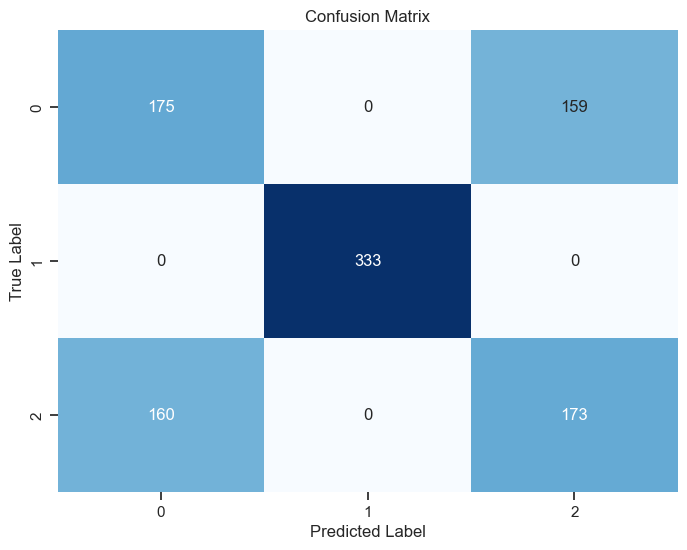

In [270]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred=X_st['remapped_km'], y_true=X_st['realLabel'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 6
consider possible pre-processing actions, repeat the fitting and evaluate as before the result of the new fitting.

I considered to standardize the dataset considering that the measures were really different and so the distances were badly computed by the algorithm, causing problems for the clustering algorithms.

So in the 2° point i standardize the dataset before eveerything

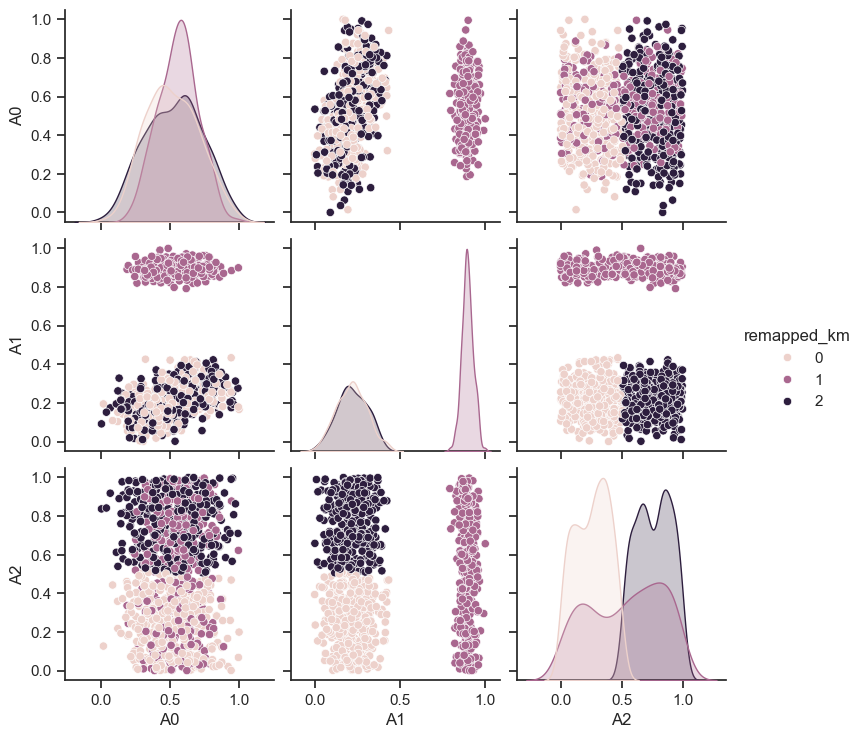

In [272]:
# Visuale clustering
sns.pairplot(data=X_st.drop(['clustering_km', 'realLabel'], axis=1), hue='remapped_km')